In [1]:
import pickle as pkl
import torch

In [2]:
with open("../data/pickles/50salads_target.pkl", "rb") as f:
    data = pkl.load(f)
with open("../data/pickles/50_salads_one_hot.pkl", "rb") as f:
    data_oh = pkl.load(f)

In [3]:
from torch.utils.data import DataLoader
from dataset.dataset import SaladsDataset
from denoisers.UnetDenoiser import UnetDenoiser
from ddpm.ddpm_multinomial import Diffusion

salads_dataset = SaladsDataset(data_oh)

In [4]:
denoiser = UnetDenoiser(in_ch=20, out_ch=20, max_input_dim=salads_dataset.sequence_length).to('cuda').float()
checkpoint = torch.load('../runs/unet_ce/last.ckpt')
denoiser.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [7]:
loader = DataLoader(
    salads_dataset,
    batch_size=10,
    shuffle=True
)

test = next(iter(loader)).to('cuda')
test

tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        ...,

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0., 

In [8]:
diffuser = Diffusion(noise_steps=200)

In [9]:
t = torch.tensor([199]).to('cuda') 
x_t, eps = diffuser.noise_data(test, t)

In [10]:
eps_hat = denoiser(x_t.permute(0, 2, 1).float(), t)

In [15]:
from torch import nn

criterion = nn.CrossEntropyLoss()
criterion(eps_hat, test.permute(0, 2, 1))

tensor(3.2845, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)

In [10]:
sqrt_alpha_hat = torch.sqrt(diffuser.alpha_hat[t])[:, None, None]
sqrt_one_minus_alpha_hat = torch.sqrt(1 - diffuser.alpha_hat[t])[:, None, None]
x_hat = diffuser.denoise(denoiser, x_t.permute(0, 2, 1).float(), t)
x_hat

D:\Projects\trace-denoise\src\ddpm\ddmp_multinomial.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t).long().to(self.device)


tensor([[[  5.7263, -20.7785,  -9.4052,  ...,   0.5287,  -8.2503, -13.0716],
         [  6.4067,   7.0115,  -2.1612,  ...,  -2.2935,   1.7831,  -0.3032],
         [ 10.0543,  13.9898,  -0.2321,  ..., -14.1483,  16.3022, -10.3928],
         ...,
         [ 10.6984,  15.1259,   6.2504,  ..., -14.2516, -18.4344,   6.0720],
         [ -0.5810,  -6.5327, -14.3074,  ...,   3.1594,   1.1031,  -2.7491],
         [-17.1704,   0.7972,   0.2797,  ...,   2.2053, -14.4310,  17.4099]]],
       device='cuda:0')

In [21]:
torch.softmax(x_hat, dim=1)[0][:, 0]

tensor([1.0950e-08, 2.1622e-08, 8.2994e-07, 6.6863e-14, 3.6213e-20, 6.1329e-09,
        5.8262e-10, 1.0000e+00, 1.6127e-17, 7.3481e-26, 6.2130e-11, 1.0840e-08,
        5.7231e-15, 2.6599e-11, 3.5455e-08, 1.6197e-10, 4.9502e-09, 1.5804e-06,
        1.9962e-11, 1.2460e-18], device='cuda:0')

In [11]:
(x_t - sqrt_one_minus_alpha_hat * eps) / sqrt_alpha_hat

tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]]], device='cuda:0',
       dtype=torch.float64)

In [24]:
eps_hat.shape

torch.Size([1, 20, 6584])

In [16]:
diffuser = Diffusion(noise_steps=200)
x_gen = diffuser.sample(denoiser, 10, 20, salads_dataset.sequence_length, 'original')
x_hat_result = torch.argmax(torch.softmax(x_gen, dim=1), dim=1)

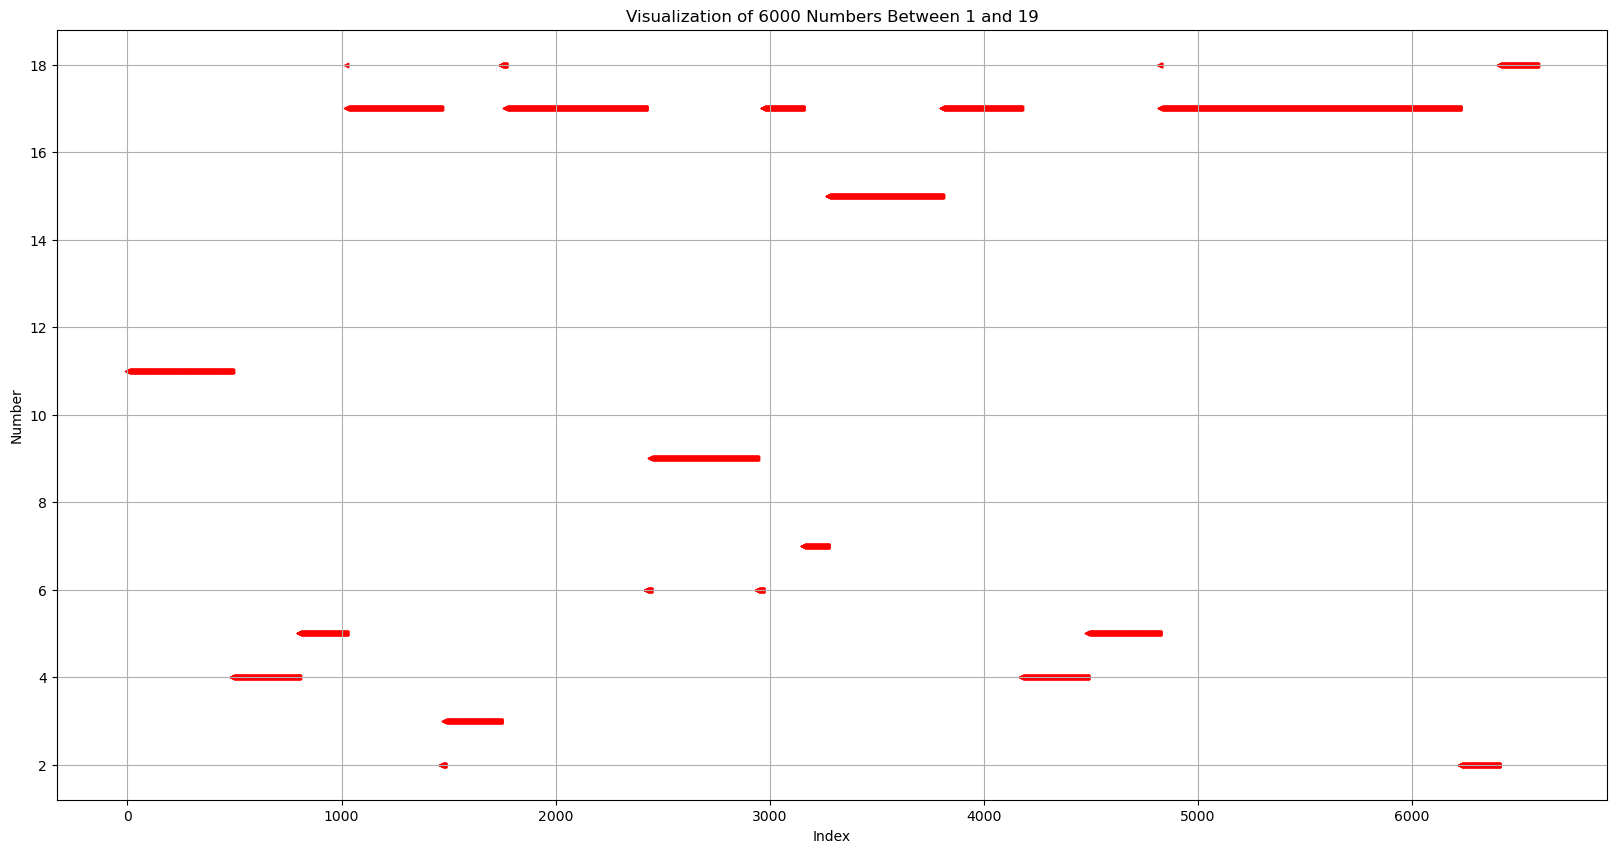

In [21]:
import matplotlib.pyplot as plt

example = x_hat_result[4].to('cpu')

plt.figure(figsize=(20, 10))
plt.scatter(range(len(example)), example, marker='<', c='r', s=10)

plt.xlabel('Index')
plt.ylabel('Number')
plt.title('Visualization of 6000 Numbers Between 1 and 19')
plt.grid(True)

plt.show()